In [2]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings('ignore')
#import os
#cwd = os.getcwd()
#print(cwd)

In [3]:
def matrixmaker(name):
    vessels = scipy.io.loadmat('Output/Vessels_' + name +'.mat') #pulls correct document as result of run_get_radii_part1
    array = vessels['vessel_details']
    table = pd.DataFrame(array)
    column_names = ['VES ID', 'CL FILE', 'LENGTH [mm]', 'MEAN RADII [mm]', 'MEDIAN RADII', 'R_STD','PARENT','DAUGHTERS','DAUGHTERS ID'] #names columns
    table.columns = column_names
    table = table.iloc[1: , :]# removes first row, leaves only data
    table = table.reset_index()
    matrix = table[['VES ID', 'LENGTH [mm]', 'MEAN RADII [mm]', 'PARENT', 'DAUGHTERS ID']]#selects specific columns we need
    vid = np.empty((0,0))
    length = np.empty((0,0))
    radius = np.empty((0,0))
    for i in np.arange(matrix.shape[0]):#takes everything out of extra arrays, mostly from weird Matlab formatting
        pv = matrix.iloc[i][0]
        vid = np.append(vid,pv)
        lengthint = matrix.iloc[i][1]
        length = np.append(length, lengthint[0][0])
        radiusint = matrix.iloc[i][2]
        radius = np.append(radius, radiusint[0][0])
    matrix['VES ID'] = vid
    matrix['LENGTH [mm]'] = length
    matrix.loc[:,'MEAN RADII [mm]'] = radius
    return matrix #returns .mat data as pandas dataframe

In [4]:
def splitint(arr):
    # Initialize an empty list to hold the final integer arrays
    result = []

    # Iterate through each string in the input array
    for item in arr:
        # Split the string by commas, strip any extra spaces, and convert to integers
        int_array = np.array([int(x.strip()) for x in item.split(',')], dtype=int)
        result.append(int_array)
    final_result = np.concatenate(result)
    return final_result

In [5]:
def alpha_beta(matrix):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    vesselid = np.empty((0,0))
    for i in np.arange(matrix.shape[0]): #cycle through every row
        dvessels = splitint(matrix.iloc[i][4]) #pulls daughter vessels
        vessel = matrix.iloc[i][0]
        vesselid = np.append(vesselid,vessel)
        if dvessels[0] == 0: #if no bifurcation, we skip
            alpha = np.append(alpha,[np.nan]) #appends NaN as placeholder
            beta = np.append(beta,[np.nan])
            continue
        pvr = matrix.iloc[i][2]
        dv1 = matrix.loc[matrix['VES ID'] == str(dvessels[0])]
        #print(dvessels[0])
        #print(dv1)
        dv1r = dv1.iloc[0][2]
        dv2 = matrix.loc[matrix['VES ID'] == str(dvessels[1])]
        dv2r = dv2.iloc[0][2]
        if dv1r > dv2r: #determines which one is alpha vs beta, then stores the data
            alphavalue = dv1r/pvr
            #print(alphavalue)
            alpha = np.append(alpha,alphavalue)
            betavalue = dv2r/pvr
            beta = np.append(beta,betavalue)
        else: 
            alphavalue = dv2r/pvr
            #print(alphavalue)
            alpha = np.append(alpha,alphavalue)
            betavalue = dv1r/pvr
            beta = np.append(beta,betavalue)
    alphabeta = pd.DataFrame({'VES ID':vesselid,'Alpha':alpha, 'Beta':beta}) # returns the alpha beta data frame
    return alphabeta

In [6]:
def lrr(table):
    vesselid = np.empty((0,0))
    lrrarray = np.empty((0,0))
    for i in np.arange(table.shape[0]): #cycles through each row
        vessel = table.iloc[i][0]
        length = table.iloc[i][1]
        radius = table.iloc[i][2]
        vesselid = np.append(vesselid,vessel) #appends ves ID
        lrr = length/radius
        lrrarray = np.append(lrrarray,lrr) #appends length to radius ratio
    lrrtable = pd.DataFrame({'VES ID':vesselid,'Length to Radius Ratio':lrrarray})
    return lrrtable #returns length-to-radius ratio as dataframe


In [7]:
name = 'PVB046_arteries' #change this in accordance to your file
table = matrixmaker(name) #update path in function to yours
alpha = alpha_beta(table) #runs alpha_beta
lrrtable = lrr(table) #runs lrr
merged = pd.merge(table,alpha,on='VES ID')
total = pd.merge(merged,lrrtable,on='VES ID') #merges all tables together
pd.set_option('display.max_rows',None)
print(total)

    VES ID  LENGTH [mm] MEAN RADII [mm]   PARENT  DAUGHTERS ID     Alpha  \
0       36    63.414698       12.467472    [[0]]       [87,90]  0.723400   
1        1    31.216603        1.429506  [[168]]       [0,0,0]       NaN   
2        2    65.161857        1.799034  [[154]]       [0,0,0]       NaN   
3        3    18.145535        1.815405  [[100]]       [0,0,0]       NaN   
4        4    23.388176        1.314327  [[125]]       [0,0,0]       NaN   
5        5    11.803119         1.42617  [[105]]       [0,0,0]       NaN   
6        6    18.656854        2.793962  [[153]]       [0,0,0]       NaN   
7        7    82.778294        2.390818  [[121]]       [0,0,0]       NaN   
8        8    29.266491        1.511805  [[103]]       [0,0,0]       NaN   
9        9    23.291800        1.774379   [[92]]       [0,0,0]       NaN   
10      10    32.266491        1.663472  [[127]]       [0,0,0]       NaN   
11      11    25.484552        1.868615   [[96]]       [0,0,0]       NaN   
12      12  

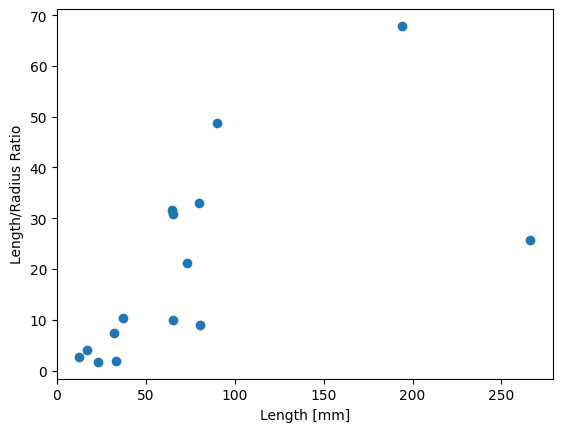

In [8]:
x = total['LENGTH [mm]']
y = total['Length to Radius Ratio']
plt.scatter(x, y)
plt.xlabel("Length [mm]")
plt.ylabel("Length/Radius Ratio")
plt.show()

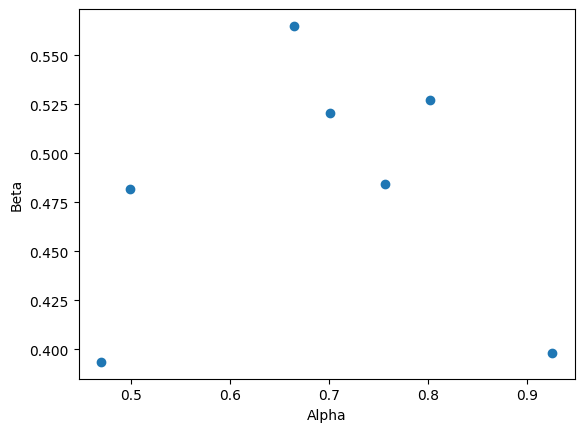

In [9]:
a = total['Alpha'].dropna()
b = total['Beta'].dropna()
plt.scatter(a, b)
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.show()

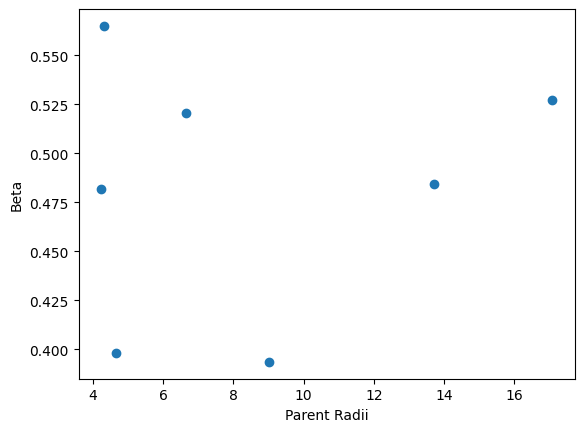

In [10]:
c = total.dropna()
d = c['MEAN RADII [mm]']
plt.scatter(d, b)
plt.xlabel("Parent Radii")
plt.ylabel("Beta")
plt.show()

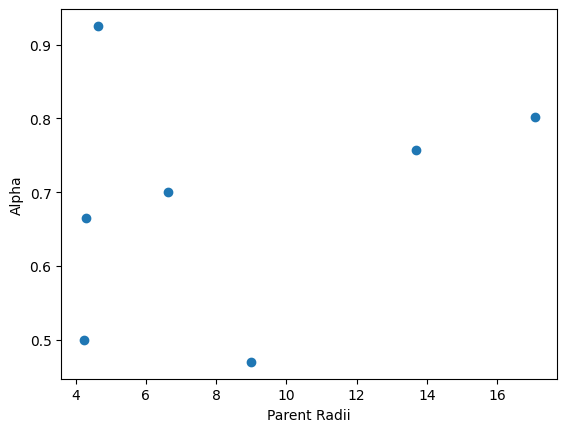

In [11]:
plt.scatter(d, a)
plt.xlabel("Parent Radii")
plt.ylabel("Alpha")
plt.show()